In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from math import exp
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2

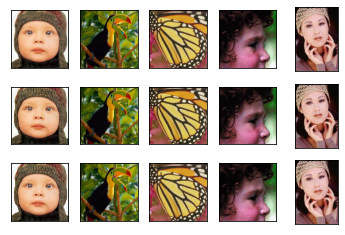

In [4]:
#多图拼接

dir1 = 'Set5\original'
dir2 = 'SRGAN-master/results2'
dir3 = 'SRCNN-master/sr2'
img_ori = []
img_gan = []
img_cnn = []
for i,file in enumerate(os.listdir(dir1)):
    file_path = dir1+'/'+file
    img_ori.append(Image.open(file_path))
for i,file in enumerate(os.listdir(dir2)):
    file_path = dir2+'/'+file
    img_gan.append(Image.open(file_path))
for i,file in enumerate(os.listdir(dir3)):
    file_path = dir3+'/'+file
    img_cnn.append(Image.open(file_path))
for i in range(5):
    plt.subplot(3,5,i+1,xticks = [],yticks = [])
    plt.imshow(img_ori[i])
    plt.subplot(3,5,i+6,xticks = [],yticks = [])
    plt.imshow(img_cnn[i])
    plt.subplot(3,5,i+11,xticks = [],yticks = [])
    plt.imshow(img_gan[i])



In [ ]:
#计算PSNR
def cal_psnr(im1, im2):
    mse = (np.abs(im1 - im2) ** 2).mean()
    psnr = 10 * np.log10(255 * 255 / mse)
    return psnr

In [ ]:
#计算SSIM
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)
    
    
def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
npImg1 = cv2.imread("SRGAN-master/results2/baby.png")
npImg2 = cv2.imread("Set5\original/baby.png")
img1 = torch.from_numpy(np.rollaxis(npImg1, 2)).float().unsqueeze(0) / 255.0
img2 = torch.from_numpy(np.rollaxis(npImg2, 2)).float().unsqueeze(0) / 255.0

ssim_value = ssim(img1, img2).item()